In [45]:
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random as rnd

# Data Preprocessing


In [46]:
def generate_sequences(data, window_size):
    X, y_capacity, y_RUL, y_SOH = [], [], [], []
    cyclic_RUL_x, cyclic_RUL_y = [], []

    cycles = data['cycle'].unique()
    initial_capacity = data.iloc[0]['capacity']

    # Normalize all 'capacity' values by the first row's 'capacity' value
    data['SOH'] = data['capacity'] / initial_capacity

    for cycle in cycles:
        cycle_data = data[data['cycle'] == cycle]
        cycle_observations = []
        num_rows = len(cycle_data)

        if num_rows >= window_size:
            for start in range(num_rows - window_size + 1):
                end = start + window_size

                features = cycle_data.iloc[start:end].drop(['cycle', 'capacity', 'RUL', 'SOH'], axis=1).values # Exclude 'cycle', 'capacity', 'RUL'
                target_capacity = cycle_data.iloc[end-1, cycle_data.columns.get_loc('capacity')] # Capacity target
                target_SOH = cycle_data.iloc[end-1, cycle_data.columns.get_loc('SOH')]
                target_RUL = cycle_data.iloc[end-1, cycle_data.columns.get_loc('RUL')] # RUL target
                cycle_observations.append(features)
                X.append(features)
                y_capacity.append(target_capacity)
                y_SOH.append(target_SOH)
                y_RUL.append(target_RUL)

            cyclic_RUL_x.append(y_capacity[-1])
            cyclic_RUL_y.append(y_RUL[-1])

    return np.array(X), np.array(y_capacity), np.array(y_SOH), np.array(y_RUL), np.array(cyclic_RUL_x), np.array(cyclic_RUL_y)

In [47]:
file_path_0005 = 'B0005_discharge.csv'
file_path_0006 = 'B0006_discharge.csv'
file_path_0007 = 'B0007_discharge.csv'
file_path_0018 = 'B0018_discharge.csv'

data_0005 = pd.read_csv(file_path_0005)
data_0006 = pd.read_csv(file_path_0006)
data_0007 = pd.read_csv(file_path_0007)
data_0018 = pd.read_csv(file_path_0018)

X_0005, y_capacit_0005, y_SOH_0005, y_RUL_0005, cyclic_RUL_x_0005, cyclic_RUL_y_0005 = generate_sequences(data_0005, 10)
X_0006, y_capacit_0006, y_SOH_0006,  y_RUL_0006, cyclic_RUL_x_0006, cyclic_RUL_y_0006 = generate_sequences(data_0006, 10)
X_0007, y_capacit_0007, y_SOH_0007,  y_RUL_0007, cyclic_RUL_x_0007, cyclic_RUL_y_0007 = generate_sequences(data_0007, 10)
X_0018, y_capacit_0018, y_SOH_0018,  y_RUL_0018, cyclic_RUL_x_0018, cyclic_RUL_y_0018 = generate_sequences(data_0018, 10)

In [48]:
X = np.concatenate((X_0005, X_0006, X_0007, X_0018), axis=0)
y_capacity = np.concatenate((y_capacit_0005, y_capacit_0006, y_capacit_0007, y_capacit_0018), axis=0)
y_SOH = np.concatenate((y_SOH_0005, y_SOH_0006, y_SOH_0007, y_SOH_0018), axis=0)
y_RUL = np.concatenate((y_RUL_0005, y_RUL_0006, y_RUL_0007, y_RUL_0018), axis=0)
cyclic_RUL_x = np.concatenate((cyclic_RUL_x_0005, cyclic_RUL_x_0006, cyclic_RUL_x_0007, cyclic_RUL_x_0018), axis=0)
cyclic_RUL_y = np.concatenate((cyclic_RUL_y_0005, cyclic_RUL_y_0006, cyclic_RUL_y_0007, cyclic_RUL_y_0018), axis=0)

# Predicting SOH/Capacity

## predicting raw capacity

This step is only added for the sake of comparing our method with baselines since they predict raw capacity rather than SOH, and this model is not part of our pipeline

In [49]:
X_capacity_train, X_capacity_testval, y_capacity_train, y_capacity_testval = train_test_split(
    X, y_capacity, test_size=0.2, random_state=42
)

X_capacity_test, X_capacity_validation, y_capacity_test, y_capacity_validation = train_test_split(
    X_capacity_testval, y_capacity_testval, test_size=0.5, random_state=42
)

In [50]:
time_steps = X_capacity_train.shape[1]
features = X_capacity_train.shape[2]

model = Sequential()

model.add(LSTM(100, return_sequences=True, input_shape=(time_steps, features)))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')

In [51]:
history = model.fit(X_capacity_train, y_capacity_train, epochs=20, validation_data=(X_capacity_validation, y_capacity_validation), verbose=1)
model.save('Raw_Capacity_LSTM.h5')

Epoch 1/20
4500/4500 [==============================] - 152s 32ms/step - loss: 0.0355 - val_loss: 0.0146
Epoch 2/20
4500/4500 [==============================] - 146s 32ms/step - loss: 0.0148 - val_loss: 0.0128
Epoch 3/20
4500/4500 [==============================] - 144s 32ms/step - loss: 0.0126 - val_loss: 0.0103
Epoch 4/20
4500/4500 [==============================] - 144s 32ms/step - loss: 0.0120 - val_loss: 0.0217
Epoch 5/20
4500/4500 [==============================] - 142s 32ms/step - loss: 0.0115 - val_loss: 0.0107
Epoch 6/20
4500/4500 [==============================] - 146s 32ms/step - loss: 0.0106 - val_loss: 0.0097
Epoch 7/20
4500/4500 [==============================] - 144s 32ms/step - loss: 0.0098 - val_loss: 0.0087
Epoch 8/20
4500/4500 [==============================] - 147s 33ms/step - loss: 0.0085 - val_loss: 0.0101
Epoch 9/20
4500/4500 [==============================] - 146s 32ms/step - loss: 0.0077 - val_loss: 0.0056
Epoch 10/20
4500/4500 [==============================] 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### testing

In [52]:
cap_model = load_model('Raw_Capacity_LSTM.h5')
cap_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 100)           43200     
                                                                 
 lstm_4 (LSTM)               (None, 10, 100)           80400     
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 209101 (816.80 KB)
Trainable params: 209101 (816.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


563/563 [==============================] - 7s 10ms/step
Mean Squared Error: 0.003621418452524672
Mean Absolute Error: 0.044903987425068397
Root Mean Squared Error: 0.06017822241080798


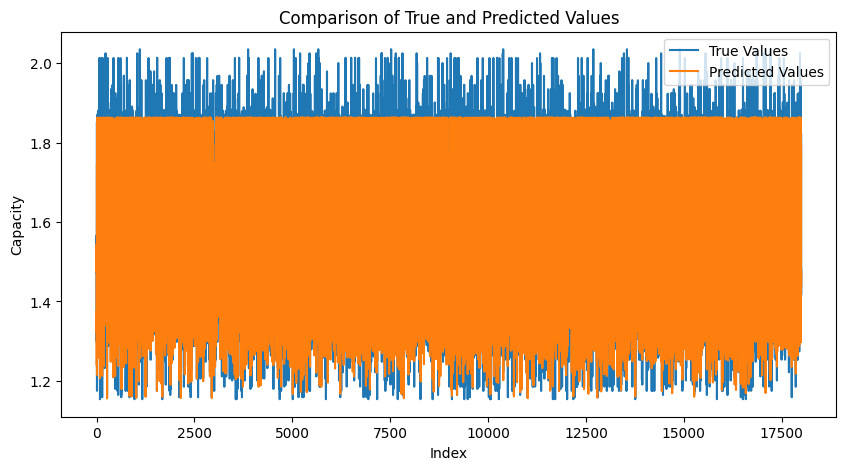

In [53]:
predicted_y = cap_model.predict(X_capacity_test)
true_y = y_capacity_test

mse = mean_squared_error(true_y, predicted_y)
mae = mean_absolute_error(true_y, predicted_y)
rmse = np.sqrt(mse)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

plt.figure(figsize=(10, 5))

plt.plot(true_y, label='True Values')

plt.plot(predicted_y, label='Predicted Values')

plt.title('Comparison of True and Predicted Values')
plt.xlabel('Index')
plt.ylabel('Capacity')
plt.legend()
plt.show()

## predicting SOH (main method)

In [54]:
X_SOH_train, X_SOH_testval, y_SOH_train, y_SOH_testval = train_test_split(
    X, y_SOH, test_size=0.2, random_state=42
)

X_SOH_test, X_SOH_validation, y_SOH_test, y_SOH_validation = train_test_split(
    X_SOH_testval, y_SOH_testval, test_size=0.5, random_state=42
)

In [55]:
time_steps = X_SOH_train.shape[1]
features = X_SOH_train.shape[2]

model = Sequential()

model.add(LSTM(100, return_sequences=True, input_shape=(time_steps, features)))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')

In [56]:
history = model.fit(X_SOH_train, y_SOH_train, epochs=20, validation_data=(X_SOH_validation, y_SOH_validation), verbose=1)
model.save('SOH_LSTM.h5')

Epoch 1/20
4500/4500 [==============================] - 153s 33ms/step - loss: 0.0101 - val_loss: 0.0046
Epoch 2/20
4500/4500 [==============================] - 143s 32ms/step - loss: 0.0049 - val_loss: 0.0035
Epoch 3/20
4500/4500 [==============================] - 151s 34ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 4/20
4500/4500 [==============================] - 146s 32ms/step - loss: 0.0039 - val_loss: 0.0042
Epoch 5/20
4500/4500 [==============================] - 144s 32ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 6/20
4500/4500 [==============================] - 147s 33ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 7/20
4500/4500 [==============================] - 148s 33ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 8/20
4500/4500 [==============================] - 146s 32ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 9/20
4500/4500 [==============================] - 144s 32ms/step - loss: 0.0028 - val_loss: 0.0034
Epoch 10/20
4500/4500 [==============================] 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Testing

In [57]:
SOH_model = load_model('SOH_LSTM.h5')
SOH_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 100)           43200     
                                                                 
 lstm_7 (LSTM)               (None, 10, 100)           80400     
                                                                 
 lstm_8 (LSTM)               (None, 100)               80400     
                                                                 
 dense_4 (Dense)             (None, 50)                5050      
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 209101 (816.80 KB)
Trainable params: 209101 (816.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


563/563 [==============================] - 6s 10ms/step
Mean Squared Error: 0.0014731521996991337
Mean Absolute Error: 0.02902831321114769
Root Mean Squared Error: 0.03838166488962059


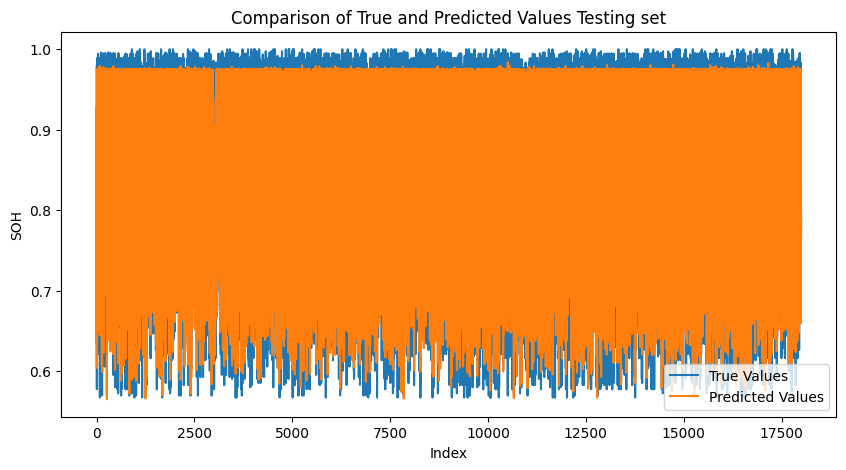

In [60]:
predicted_y = SOH_model.predict(X_SOH_test)
true_y = y_SOH_test

mse = mean_squared_error(true_y, predicted_y)
mae = mean_absolute_error(true_y, predicted_y)
rmse = np.sqrt(mse)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

plt.figure(figsize=(10, 5))

plt.plot(true_y, label='True Values')

plt.plot(predicted_y, label='Predicted Values')

plt.title('Comparison of True and Predicted Values Testing set')
plt.xlabel('Index')
plt.ylabel('SOH')
plt.legend()
plt.show()

4500/4500 [==============================] - 56s 13ms/step
Mean Squared Error: 0.001495261970469257
Mean Absolute Error: 0.029220239069449493
Root Mean Squared Error: 0.038668617385022405


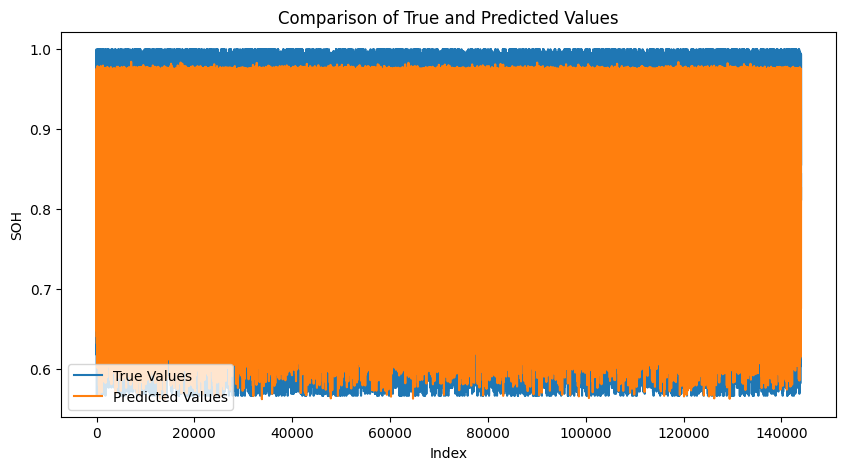

In [59]:
predicted_y = SOH_model.predict(X_SOH_train)
true_y = y_SOH_train

mse = mean_squared_error(true_y, predicted_y)
mae = mean_absolute_error(true_y, predicted_y)
rmse = np.sqrt(mse)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

plt.figure(figsize=(10, 5))

plt.plot(true_y, label='True Values')

plt.plot(predicted_y, label='Predicted Values')

plt.title('Comparison of True and Predicted Values Training set')
plt.xlabel('Index')
plt.ylabel('SOH')
plt.legend()
plt.show()

# Predicting RUL

In [30]:
cyclic_RUL_x_reshaped = np.empty((cyclic_RUL_x.shape[0], 1))
for i in range(cyclic_RUL_x.shape[0]):
  cyclic_RUL_x_reshaped[i] = np.array([cyclic_RUL_x[i]])

In [31]:
scaler = MinMaxScaler()
scaled_rul = scaler.fit_transform(cyclic_RUL_y.reshape(-1, 1))

In [32]:
def generate_sequences_RUL(capacity, RUL_GT, window_size):
  X, y_RUL = [], []
  for start in range(capacity.shape[0] - window_size + 1):
    end = start + window_size

    features = capacity[start:end]
    target_RUL = RUL_GT[end-1]
    X.append(features)
    y_RUL.append(target_RUL)

  return np.array(X), np.array(y_RUL)

In [33]:
X_for_RUL, y_RUL = generate_sequences_RUL(cyclic_RUL_x_reshaped, scaled_rul, 3)

In [38]:
X_RUL_train, X_RUL_testval, y_RUL_train, y_RUL_testval = train_test_split(
    X_for_RUL, y_RUL, test_size=0.1, random_state=42
)

X_RUL_test, X_RUL_validation, y_RUL_test, y_RUL_validation = train_test_split(
    X_RUL_testval, y_RUL_testval, test_size=0.5, random_state=42
)

In [40]:
model = Sequential()
model.add(LSTM(units=200, return_sequences=True, input_shape=(X_RUL_train.shape[1],1)))
model.add(Dropout(0.3))
model.add(LSTM(units=200, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=200))
model.add(Dropout(0.3))
model.add(Dense(units=50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer='adam',loss='mean_squared_error')

In [41]:
history = model.fit(X_RUL_train, y_RUL_train, epochs=200, validation_data=(X_RUL_validation, y_RUL_validation), verbose=1)
model.save('RUL_LSTM.h5')

Epoch 1/200
18/18 [==============================] - 9s 126ms/step - loss: 0.1270 - val_loss: 0.0815
Epoch 2/200
18/18 [==============================] - 1s 53ms/step - loss: 0.0686 - val_loss: 0.0438
Epoch 3/200
18/18 [==============================] - 1s 35ms/step - loss: 0.0678 - val_loss: 0.0356
Epoch 4/200
18/18 [==============================] - 1s 33ms/step - loss: 0.0641 - val_loss: 0.0289
Epoch 5/200
18/18 [==============================] - 1s 35ms/step - loss: 0.0546 - val_loss: 0.0358
Epoch 6/200
18/18 [==============================] - 1s 35ms/step - loss: 0.0408 - val_loss: 0.0191
Epoch 7/200
18/18 [==============================] - 1s 46ms/step - loss: 0.0295 - val_loss: 0.0132
Epoch 8/200
18/18 [==============================] - 1s 67ms/step - loss: 0.0247 - val_loss: 0.0062
Epoch 9/200
18/18 [==============================] - 1s 56ms/step - loss: 0.0262 - val_loss: 0.0062
Epoch 10/200
18/18 [==============================] - 1s 50ms/step - loss: 0.0242 - val_loss: 0.011

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### testing

In [42]:
RUL_model = load_model('RUL_LSTM.h5')
RUL_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 200)            161600    
                                                                 
 dropout (Dropout)           (None, 3, 200)            0         
                                                                 
 lstm_1 (LSTM)               (None, 3, 200)            320800    
                                                                 
 dropout_1 (Dropout)         (None, 3, 200)            0         
                                                                 
 lstm_2 (LSTM)               (None, 200)               320800    
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense (Dense)               (None, 50)               

1/1 [==============================] - 0s 29ms/step
Mean Squared Error: 0.014214227490196778
Mean Absolute Error: 0.09035893150432384
Root Mean Squared Error: 0.11922343515516058


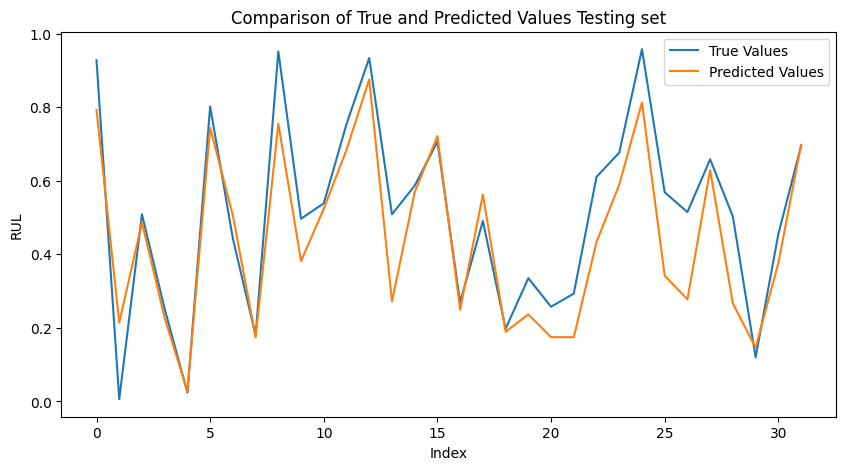

In [61]:
predicted_y = RUL_model.predict(X_RUL_test)
true_y = y_RUL_test

mse = mean_squared_error(true_y, predicted_y)
mae = mean_absolute_error(true_y, predicted_y)
rmse = np.sqrt(mse)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

plt.figure(figsize=(10, 5))

plt.plot(true_y, label='True Values')

plt.plot(predicted_y, label='Predicted Values')

plt.title('Comparison of True and Predicted Values Testing set')
plt.xlabel('Index')
plt.ylabel('RUL')
plt.legend()
plt.show()

18/18 [==============================] - 0s 17ms/step
Mean Squared Error: 0.008759947689006934
Mean Absolute Error: 0.0730384256403879
Root Mean Squared Error: 0.09359459219958668


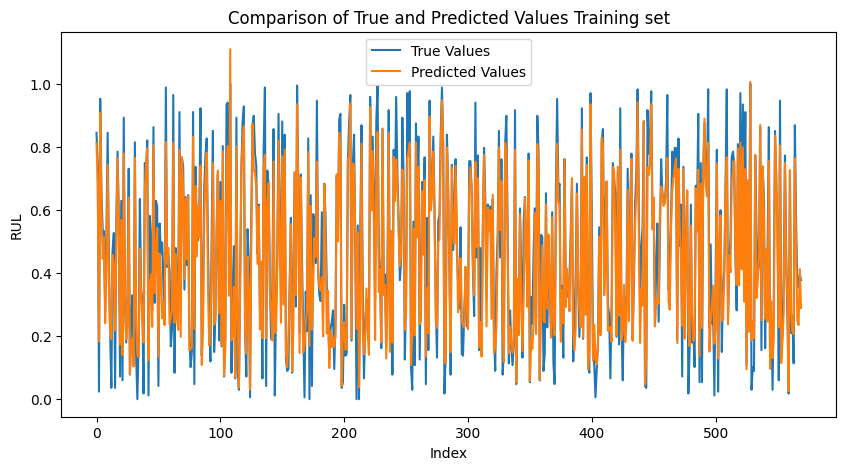

In [62]:
predicted_y = RUL_model.predict(X_RUL_train)
true_y = y_RUL_train

mse = mean_squared_error(true_y, predicted_y)
mae = mean_absolute_error(true_y, predicted_y)
rmse = np.sqrt(mse)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

plt.figure(figsize=(10, 5))

plt.plot(true_y, label='True Values')

plt.plot(predicted_y, label='Predicted Values')

plt.title('Comparison of True and Predicted Values Training set')
plt.xlabel('Index')
plt.ylabel('RUL')
plt.legend()
plt.show()